In [1]:
import underworld as uw
from underworld import function as fn
#import UWGeodynamics as GEO
#from underworld.scaling import units as u
#from underworld.scaling import dimensionalise, non_dimensionalise
import math
import numpy as np
import underworld.visualisation as glucifer
#import glucifer
import os

rank = uw.mpi.rank

## Basic Model Parameters and Scaling

In [2]:
KL_meters    = 30000. #* u.meter
K_viscosity  = 1.0e14 #* u.pascal * u.second
K_density    = 916.8 #* u.kilogram / (u.meter**3)
Kt_seconds   = 30000. ** 2 / 1.4e-6
KM_kilograms = K_viscosity * KL_meters * Kt_seconds

K_substance  = 1. #* u.mole
KT_degrees   = 173. #* u.kelvin
K_pascal     = K_viscosity / Kt_seconds

print('KM_kilograms  = {}'.format(KM_kilograms))
print('Kt_seconds  = {}'.format(Kt_seconds))
print('K_pascal = {}'.format(K_pascal))



KM_kilograms  = 1.9285714285714285e+33
Kt_seconds  = 642857142857142.9
K_pascal = 0.15555555555555556


In [3]:
Yres      = 96
Xres      = int(Yres * 3 / 2)
boxHeight = 30000. #* u.meter #33. * u.kilometer
boxLength = boxHeight * 3. / 2.
Tmin      = 100. #* u.kelvin
Tmax      = 273. #* u.kelvin
Tc        = 250. #* u.kelvin
deltaT    = Tmax - Tmin
deltaTc   = Tc - Tmin

In [4]:
K = 1.4e-6 #* (u.meter**2) * (u.second**(-1)) #Diffusivity

rho = 916.8 #* u.kilogram / u.meter**3 #Density

maxRho = 999.0 #maximum density difference

DelRho = maxRho - rho

rhoSalt = 1444. #* u.kilogram / u.meter**3

alpha = 1.56e-4 #/ u.kelvin #Thermal Compressibility

g = 1.315 #* u.meter / u.second**2
# Compressibility in /bar: placeholder value at ~250 K from Marion & Jakubawski (2004)
beta = 2.5e-4 #/ u.bar

Beta = 9.4

etaref = 1.0e14 #* u.pascal * u.second

etamax = 1.0e20 #* u.pascal * u.second

Y = 0.9 #* u.gigapascal #Young's Modulus

G = 3.6 #* u.gigapascal #Shear Modulus

sigy = 1.0e6 #* u.pascal  #Yield Stress

Ra = (rho * alpha * g * deltaT * boxHeight ** 3) / (etaref * K)

Rb = (DelRho * g * boxHeight ** 3) / (etaref * K)

In [5]:
print('rho  = {}'.format(rho))
print('alpha  = {}'.format(alpha))
print('g  = {}'.format(g))
print('DeltaT  = {}'.format(deltaT))
print('b^3  = {}'.format(boxHeight ** 3))
print('K  = {}'.format(K))
print('eta  = {}'.format(etaref))
print('Ra  = {}'.format(Ra))
print('Rb  = {}'.format(Rb))


rho  = 916.8
alpha  = 0.000156
g  = 1.315
DeltaT  = 173.0
b^3  = 27000000000000.0
K  = 1.4e-06
eta  = 100000000000000.0
Ra  = 6274899.687085714
Rb  = 20846507.142857153


In [6]:
g_s = g / (KL_meters / Kt_seconds ** 2)
rho_s = rho / K_density
DelRho_s = DelRho / rho
rhoSalt_s = rhoSalt / K_density
alpha_s = alpha * KT_degrees
etaref_s = etaref / K_viscosity
etamax_s = etamax / K_viscosity
K_s = K / (KL_meters ** 2 / Kt_seconds)
Lx = boxLength / KL_meters 
Ly = boxHeight / KL_meters #non_dimensionalise(boxHeight)
Tmin_s1 = Tmin / KT_degrees
Tmax_s1 = Tmax / KT_degrees
Tmin_s = (Tmin-Tmin)/(Tmax-Tmin)
Tmax_s = (Tmax-Tmin)/(Tmax-Tmin)
Tc_s = (Tc - Tmin)/(Tmax-Tmin)
#beta_s = non_dimensionalise(beta)
sigy_s = sigy / K_pascal

Ra_s = (rho_s * alpha_s * g_s * (Tmax_s1-Tmin_s1) * Ly ** 3) / (etaref_s * K_s)

In [7]:
print('rho_s  = {}'.format(rho_s))
print('alpha_s  = {}'.format(alpha_s))
print('g_s  = {}'.format(g_s))
print('K_s  = {}'.format(K_s))
print('eta_s  = {}'.format(etaref_s))
print('Ra_s  = {}'.format(Ra_s))
print('sigy_s = {}'.format(sigy_s))
print('DelRho_s  = {}'.format(DelRho_s))

rho_s  = 1.0
alpha_s  = 0.026987999999999998
g_s  = 1.8114795918367348e+25
K_s  = 1.0
eta_s  = 1.0
Ra_s  = 4.8888211224489785e+23
sigy_s = 6428571.428571428
DelRho_s  = 0.0896596858638744


## Flags, Switches, and Variables: Change These!

In [8]:
#Flags and Switches

LoadFromFile = False #Check this to load a previously saved run (Note: not fully integrated yet)

Testing = False #If True, will run model for 10 timesteps. If false, will run for 500 timesteps.

SaltDensity = False # Change flag to True if chemical density is driven by salt fraction in ice. False prescribes an arbitrary
                    # Density difference.
    
BuffoHiSalt = False #Activates depth-dependent hi-salt-content profile from Buffo et al. 2020 (Not yet integrated)
BuffoLoSalt = False #Activates depth-dependent lo-salt-content profile from Buffo et al. 2020 (Not yet integrated)

In [9]:
#Batch Job Info
Batch = 1  #Batch number
Trial = 1  #for batch submitting jobs. Labels output files with trial number.

In [10]:
#Domain Variables: Change these numbers to rearrange the size and position of crust, keel, and lens.

CrustThickness = 3000.# * u.kilometer

KeelRadius = 5000.# * u.kilometer

LensGap = 0.# * u.kilometer #distance between bottom of keel and top of lens

LensWidth = 2. * KeelRadius #Half-width of lens

LensHeight = KeelRadius #full height of lens

LensOffset = 0. #* u.kilometer #horizontal offset of lens from center of box

SurfaceLayer = 300. # Thickness of surface-tracking particles in keel.

In [11]:
#Density and Viscosity Variables: Porosity, Salt Content, Prescribed Density.

# Porosity of each model region.
PhiLens = 0.0
PhiCrust = 0.00
PhiShell = 0.0
PhiKeel = 0.0 #PhiCrust
#PhiAir = 0.5

# Salt fraction of each model region.

fSLens = 0.0
fSCrust = 0.0
fSShell = 0.0
fSKeel = 0.2

#Prescribed density
RBG = 0.0 #Density of non-keel regions
DRK = 1.0 #fraction of maximum density difference in keel

#Prescribed keel weakening
EtaFrac = 75.0 #magnitude of viscous weakening in keel

## Model Domain Setup

In [12]:
#Domain Variables: Change these numbers to rearrange the size and position of crust, keel, and lens.

TopShell = 30000.# * u.kilometer


TS = TopShell / KL_meters#non_dimensionalise(TopShell)
CT = CrustThickness/ KL_meters#non_dimensionalise(CrustThickness)
KR = KeelRadius / KL_meters#non_dimensionalise(KeelRadius)
LG = LensGap / KL_meters#non_dimensionalise(LensGap)
LW = LensWidth / KL_meters#non_dimensionalise(LensWidth)
LS = LensHeight / KL_meters#non_dimensionalise(LensHeight)
LO = LensOffset / KL_meters#non_dimensionalise(LensOffset)
LH = LensHeight / KL_meters#non_dimensionalise(LensHeight)
SL = SurfaceLayer / KL_meters

#Coordinate setup based on above variable assignments
CenterX = Lx #/ 2.0
CenterY = TS / 2.0

BottomCrust = TS - CT
BC = BottomCrust

LensRadius = LH / 2.
LR = LensRadius

TopLens = BottomCrust - KR - LG
TL = TopLens

BottomLens = TopLens - LH
BL = BottomLens

LeftLens = CenterX - LW + LO
LL = LeftLens

RightLens = CenterX + LW + LO
RL = RightLens

LensCenter = TL - LR
LC = LensCenter

In [13]:
#Mesh setup, definition of mesh initial conditions
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"),
                                 elementRes  = (Xres,Yres),
                                 minCoord    = (0.0,0.0),
                                 maxCoord    = (Lx,Ly))

# Setup velocity and pressure field
velocityField       = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount = 2 )
pressureField       = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount = 1 )
temperatureDotField = uw.mesh.MeshVariable( mesh=mesh, nodeDofCount = 1)
temperatureField = uw.mesh.MeshVariable( mesh=mesh, nodeDofCount=1 )

#material indexes
#AirIndex = 0
ShellIndex = 1
CrustIndex = 2
KeelIndex = 3
LensIndex = 4
SurfaceIndex = 5

In [14]:
#Establish input/output path
outputPath = 'IceDripDataBatch{}/'.format(Batch)

os.makedirs(outputPath, exist_ok=True)

#if not os.path.exists(outputPath):
#    os.makedirs(outputPath)
inputPath = 'DripCheckpoints/'

In [15]:

velocityField.data[:]       = [0.,0.]

In [16]:
if(LoadFromFile == True):
# set up mesh to import data--Useful if checkpointed data does not match model resolution
    mesh32 = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"), 
                                               elementRes = (Xres, Yres), 
                                                 minCoord = (0., 0.), 
                                                 maxCoord = (boxLength, boxHeight)  )
    temperatureField32 = uw.mesh.MeshVariable( mesh=mesh32,         nodeDofCount=1 )
    temperatureDotField32 = uw.mesh.MeshVariable( mesh=mesh, nodeDofCount = 1)
    pressureField32    = uw.mesh.MeshVariable( mesh=mesh32.subMesh, nodeDofCount=1 )
    velocityField32    = uw.mesh.MeshVariable( mesh=mesh32,         nodeDofCount=2 )

    temperatureField32.load(inputPath+'IceDrip_T.out')
    temperatureDotField32.load(inputPath+'IceDrip_TDot.out')
    velocityField32.load(inputPath+'IceDrip_v.out')
    pressureField32.load(inputPath+'IceDrip_P.out')
    #transfer data onto model mesh
    temperatureField.data[:] = temperatureField32.evaluate(mesh)
    temperatureDotField.data[:] = temperatureDotField32.evaluate(mesh)
    pressureField.data[:] = pressureField32.evaluate(mesh.subMesh)
    velocityField.data[:] = velocityField32.evaluate(mesh)
    #Load material data onto swarm
    swarm = uw.swarm.Swarm( mesh=mesh )
    materialVariable = swarm.add_variable( dataType="int", count=1)
    swarm.load(outputPath+'IceDripSwarm.h5')
    materialVariable.load(outputPath+'IceDripMV.h5')
    
    #Will also need to load stress history swarm variable when viscoelasticity is integrated
    
    # load summary statistics into arrays
    data = np.loadtxt(inputPath+'IceDripSummary.out', unpack=True )
    timeVal, vrmsVal = data[0].tolist(), data[1].tolist()

In [17]:
#material domain allocation

#StickyAir = GEO.shapes.Layer(top=Ly, bottom=TS)
#Crust = GEO.shapes.Layer(top=TS, bottom=BC)
#BottomKeel  = GEO.shapes.Disk(center=(CenterX, BC), radius=KR)

#TopKeel = GEO.shapes.Box(top=TS, bottom=BC,
#                        minX=CenterX-KR, maxX=CenterX+KR)
#Keel = TopKeel | BottomKeel
#Lens1 = GEO.shapes.Box(top=TL, bottom=BL,
#                       minX=LL, maxX=RL)
#Lens2 = GEO.shapes.Disk(center=(LL,LC), radius=LR)
#Lens3 = GEO.shapes.Disk(center=(RL,LC), radius=LR)
#Lens = Lens1 | Lens2 | Lens3

TopKeela = np.array([ (CenterX,TS), (CenterX,BC), (CenterX-KR, BC), (CenterX-KR, TS) ])
TopKeel = fn.shape.Polygon(TopKeela)

Surfacea = np.array([ (CenterX,TS), (CenterX,(TS-SL)), (CenterX-KR, (TS-SL)), (CenterX-KR, TS) ])
Surface = fn.shape.Polygon(Surfacea)

Lensa = np.array([ (CenterX,TL), (LL,TL), (LL, BL), (CenterX, BL) ])
Lens = fn.shape.Polygon(Lensa)


In [18]:
if(LoadFromFile == False):
#Initialize mesh variables and define initial temperature conditions. Set up particle swarm.
    velocityField.data[:]       = [0.,0.]
    pressureField.data[:]       = 0.
    temperatureDotField.data[:] = 0.
    #temperatureField.data[:] = 1.0
    timeVal = []
    vrmsVal = []
    swarm = uw.swarm.Swarm( mesh=mesh )
    materialVariable = swarm.add_variable( dataType="int", count=1)    
    slabvar1 = swarm.add_variable( dataType="int", count=1)
    slabvar2 = swarm.add_variable( dataType="int", count=1)
    swarmLayout = uw.swarm.layouts.PerCellSpaceFillerLayout( swarm = swarm, particlesPerCell=20)
    swarm.populate_using_layout( layout=swarmLayout )
    population_control = uw.swarm.PopulationControl(swarm,aggressive=True, particlesPerCell=20)

    materialVariable.data[:] = ShellIndex
       
#    for index, coord in enumerate(mesh.data):
#        slabProf = -(Tc / slabThickness) * coord[1] + (Tc / slabThickness)
#        adiabat = -(slabThickness / Tc) * coord[1] + 1.
#        if coord[1] >= h:
#            temperatureField.data[index] = slabProf
#        if coord[1] < h:
#            temperatureField.data[index] = adiabat

            
    for index in range( len(swarm.particleCoordinates.data) ):
        coord = swarm.particleCoordinates.data[index][:]
        x = coord[0]
        z = coord[1]
        xx1 = x - CenterX
        zz1 = z - BC
        condition1 = (xx1*xx1 + zz1*zz1 < KR**2)
        xx2 = x - LL
        zz2 = z - LC
        condition2 = (xx2*xx2 + zz2*zz2 < LR**2)
        #if lowerMantle.evaluate(tuple(coord)):
            #materialVariable.data[index] = lowerMantleIndex
        if(condition1 == True):
            materialVariable.data[index] = KeelIndex
        elif(TopKeel.evaluate(tuple(coord))):
            materialVariable.data[index] = KeelIndex
        elif(coord[1] >= BC):
            materialVariable.data[index] = CrustIndex

        #if StickyAir.evaluate(tuple(coord)):
            #materialVariable.data[index] = AirIndex
        if(Surface.evaluate(tuple(coord))):
            materialVariable.data[index] = SurfaceIndex
        if Lens.evaluate(tuple(coord)):
            materialVariable.data[index] = LensIndex
        if(condition2 == True):
            materialVariable.data[index] = LensIndex


In [19]:
# build a tracer swarm with one particle
tracerParticle1 = uw.swarm.Swarm(mesh)
advector_tracer1 = uw.systems.SwarmAdvector( swarm=tracerParticle1, velocityField=velocityField, order=2 )

tracerParticle2 = uw.swarm.Swarm(mesh)
advector_tracer2 = uw.systems.SwarmAdvector( swarm=tracerParticle2, velocityField=velocityField, order=2 )

tracerParticle3 = uw.swarm.Swarm(mesh)
advector_tracer3 = uw.systems.SwarmAdvector( swarm=tracerParticle3, velocityField=velocityField, order=2 )

tracerParticle4 = uw.swarm.Swarm(mesh)
advector_tracer4 = uw.systems.SwarmAdvector( swarm=tracerParticle4, velocityField=velocityField, order=2 )

# build a numpy array with one particle, specifying it's exact location
x_pos1 = CenterX - KR
y_pos1 = TS
x_pos2 = CenterX - (KR/2)
y_pos2 = BC
x_pos3 = CenterX
y_pos3 = BC-KR
coord_array1 = np.array(object=(x_pos1,y_pos1),ndmin=2)
tracerParticle1.add_particles_with_coordinates(coord_array1)
coord_array2 = np.array(object=(x_pos2,y_pos1),ndmin=2)
tracerParticle2.add_particles_with_coordinates(coord_array2)
coord_array3 = np.array(object=(x_pos3,y_pos2),ndmin=2)
tracerParticle3.add_particles_with_coordinates(coord_array3)
coord_array4 = np.array(object=(x_pos3,y_pos3),ndmin=2)
tracerParticle4.add_particles_with_coordinates(coord_array4)

# define a y coordinate `min_max` function
fn_ycoord = fn.view.min_max( fn.coord()[1] )
fn_xcoord = fn.view.min_max( fn.coord()[0] )
def GetSwarm1XMin():
    fn_xcoord.reset()
    fn_xcoord.evaluate(tracerParticle1)
    return fn_xcoord.min_global()
def GetSwarm2XMin():
    fn_xcoord.reset()
    fn_xcoord.evaluate(tracerParticle2)
    return fn_xcoord.min_global()
def GetSwarm3YMin():
    fn_ycoord.reset()
    fn_ycoord.evaluate(tracerParticle3)
    return fn_ycoord.min_global()
def GetSwarm4YMin():
    fn_ycoord.reset()
    fn_ycoord.evaluate(tracerParticle4)
    return fn_ycoord.min_global()

In [20]:
xmin1 = GetSwarm1XMin()
if rank==0:
    print('Minimum x value for keel surface boundary = {0:.3e}'.format(xmin1))
xmin2 = GetSwarm2XMin()
if rank==0:
    print('Minimum x value for keel surface interior = {0:.3e}'.format(xmin2))
ymin1 = GetSwarm3YMin()
if rank==0:
    print('Minimum y value for keel interior = {0:.3e}'.format(ymin1))
ymin2 = GetSwarm4YMin()
if rank==0:
    print('Minimum y value for keel base = {0:.3e}'.format(ymin2))

Minimum x value for keel surface boundary = 1.333e+00
Minimum x value for keel surface interior = 1.417e+00
Minimum y value for keel interior = 9.000e-01
Minimum y value for keel base = 7.333e-01



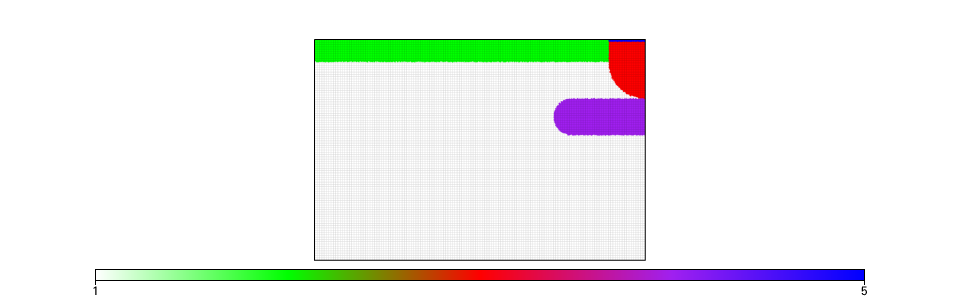

In [21]:
figParticle = glucifer.Figure(figsize=(960,300))
figParticle.append( glucifer.objects.Points(swarm, materialVariable, pointSize=2, colours='white green red purple blue') )
figParticle.append( glucifer.objects.Mesh(mesh, opacity=0.1))
figParticle.show()

In [22]:
dTc = Tmin_s - Tc_s
dzc = CT
dzl = TS - BL
dTm = Tc_s - Tmax_s

if(LoadFromFile == False):
    for index, coord in enumerate(mesh.data):
        temperatureField.data[:] = 1.0
    for index, coord in enumerate(mesh.data):
        x = coord[0]
        z = coord[1]
        xx = x - CenterX
        zz = z - BC
        condition = (xx*xx + zz*zz < KR**2)
        if(condition == True):
            temperatureField.data[index] = Tmin_s + (dTc/dzl)*(coord[1]-TS)
        elif coord[1] <= BC:
            temperatureField.data[index] = (dTm/BC)*coord[1]+Tmax_s
        elif coord[1] >=BC:
            temperatureField.data[index] = Tmin_s + (dTc/dzc)*(coord[1]-TS)
        if coord[1] >= TS:
            temperatureField.data[index] = Tmin_s
        



In [23]:
fig1 = glucifer.Figure()
fig1.append( glucifer.objects.Surface(mesh, temperatureField) )
fig1.append( glucifer.objects.VectorArrows(mesh, velocityField / 500., arrowHead=0.2, scaling=0.1) )
#fig1.append( glucifer.objects.Mesh(mesh))
#fig1.show()

In [24]:
PhiMap = { LensIndex  : PhiLens,
           CrustIndex : PhiCrust,
           ShellIndex : PhiShell,
           KeelIndex  : PhiKeel,
           SurfaceIndex : PhiKeel}
           #AirIndex   : PhiAir   }

fSMap = {  LensIndex    : fSLens,
           CrustIndex   : fSCrust,
           ShellIndex   : fSShell,
           KeelIndex    : fSKeel,
           SurfaceIndex : fSKeel}
           #AirIndex   : fSAir   }

Phi = fn.branching.map( fn_key = materialVariable, mapping = PhiMap)

fS = fn.branching.map( fn_key = materialVariable, mapping = fSMap)

figPhi = glucifer.Figure(figsize=(960,300))
figPhi.append( glucifer.objects.Points(swarm, Phi, pointSize=2,) )
figPhi.append( glucifer.objects.Mesh(mesh, opacity=0.1))
#figPhi.show()

figfS = glucifer.Figure(figsize=(960,300))
figfS.append( glucifer.objects.Points(swarm, fS, pointSize=2,) )
figfS.append( glucifer.objects.Mesh(mesh, opacity=0.1))
#figfS.show()


In [25]:
#Defining Density Function
#Rb = Ra

if SaltDensity == True:
    DeltaRho = -rho_s*Phi+fS*(rhoSalt_s-rho_s)

    DeltaRho = fn.misc.min(DeltaRho,DelRho_s) # This ensures the ice is never more dense than water.

    Density = DeltaRho #+ rho_s

    DensityMap = { LensIndex  : Density,
                   CrustIndex : Density,
                   ShellIndex : Density,
                   KeelIndex  : Density,
                   SurfaceIndex  : Density }#DeltaRho  }
                   #AirIndex   : DeltaRho   }
else:
    rhoBG = RBG
    DeltaRhoKeel = DelRho_s * DRK # Max density difference is DelRho_s (0.89). Scaled to density of ice. positive is more dense.
                                  # Manipulate number in denominator to modulate density difference of keel.
    DensityMap = { LensIndex  : rhoBG,
                   CrustIndex : rhoBG,
                   ShellIndex : rhoBG,
                   KeelIndex  : DeltaRhoKeel,
                   SurfaceIndex  : DeltaRhoKeel}

DensityFn = fn.branching.map( fn_key = materialVariable, mapping = DensityMap)


DensityFn_s = Ra * temperatureField - Rb * (DensityFn / DelRho_s)

figDensity = glucifer.Figure(figsize=(960,300))
figDensity.append( glucifer.objects.Points(swarm, DensityFn, pointSize=2,) )
figDensity.append( glucifer.objects.Mesh(mesh, opacity=0.1))
#figDensity.show()

figDensity_s = glucifer.Figure(figsize=(960,300))
figDensity_s.append( glucifer.objects.Points(swarm, DensityFn_s, pointSize=2,) )
figDensity_s.append( glucifer.objects.Mesh(mesh, opacity=0.1))
#figDensity_s.show()

In [26]:
#define rheology

etamax_s = etamax_s #Testing viscous flow law stuff

#Temperature-Dependent viscous rheology
frankKam = (etamax_s * fn.math.exp(-1.0 * np.log(etamax_s) * temperatureField)) #* ((1. - Phi)**Beta)


#Plastic failure criterion
strainRate_2ndInvariant = fn.tensor.second_invariant( 
                            fn.tensor.symmetric( 
                            velocityField.fn_gradient ))

cohesion = sigy_s #2449479.5 

#vonMises = 1000.
    
vonMises = 0.5 * cohesion / (strainRate_2ndInvariant+1.0e-18)

figStrainRate = glucifer.Figure(name="strain Rate", figsize=(960,300) )
StrainRate =glucifer.objects.Surface(mesh, strainRate_2ndInvariant)
figStrainRate.append( StrainRate )
StrainRate.colourBar["ticks"] = 10
#figStrainRate.show()

In [27]:
ShellVisc = frankKam
CrustVisc = fn.exception.SafeMaths(fn.misc.min(vonMises, ShellVisc))
KeelVisc1 = frankKam / EtaFrac # Viscous-only Keel. Manipulate number in denominator to weaken keel wrt rest of crust.
KeelVisc2 = fn.exception.SafeMaths(fn.misc.min(vonMises, KeelVisc1)) # adds plastic failure
StickyAir = 1.0

viscousOnlyMap = { LensIndex  : ShellVisc,
                   CrustIndex : ShellVisc,
                   ShellIndex : ShellVisc,
                   KeelIndex  : KeelVisc1,
                   SurfaceIndex  : KeelVisc1}
                 #AirIndex   : StickyAir   }
    
viscosityMap = {  LensIndex  : ShellVisc,
                  CrustIndex : CrustVisc,
                  ShellIndex : ShellVisc,
                  KeelIndex  : KeelVisc2,
                  SurfaceIndex  : KeelVisc2}

viscousOnlyFn = fn.branching.map( fn_key = materialVariable, mapping = viscousOnlyMap)
viscosityFn = fn.branching.map( fn_key = materialVariable, mapping = viscosityMap)

figViscosity= glucifer.Figure(name="Viscosity", figsize=(960,300) )
figViscosity.append( glucifer.objects.Mesh(mesh, opacity=0.1))
figViscosity.append( glucifer.objects.Points(swarm     = swarm, 
                                             fn_colour = viscosityFn, 
                                             pointSize = 1.0, 
                                             #fn_mask   = materialFilter,
                                             logScale  = True))
#figViscosity.colourbar["ticks"] = 6
#figViscosity.show()



In [28]:
z_hat = (0.0, 1.0)

buoyancyFn = DensityFn_s * z_hat

In [29]:
#Define T and V BCs
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
topWall = mesh.specialSets["MaxJ_VertexSet"]
bottomWall = mesh.specialSets["MinJ_VertexSet"]

    
TBC = jWalls #iWalls + jWalls
VxBC = iWalls
VyBC = jWalls

velocityBCs = uw.conditions.DirichletCondition( variable        = velocityField,
                                                indexSetsPerDof = (VxBC, VyBC) )

temperatureBCs = uw.conditions.DirichletCondition( variable        = temperatureField,
                                                   indexSetsPerDof = (TBC) )

## System and Solver Setup, Time-Stepping Loop

In [30]:
#Systems setup
stokes = uw.systems.Stokes( velocityField = velocityField,
                            pressureField = pressureField,
                            voronoi_swarm = swarm,
                            conditions    = velocityBCs,
                            fn_viscosity  = viscosityFn,
                            fn_bodyforce  = buoyancyFn )

stokesInit = uw.systems.Stokes( velocityField = velocityField,
                                pressureField = pressureField,
                                voronoi_swarm = swarm,
                                conditions    = velocityBCs,
                                fn_viscosity  = viscousOnlyFn,
                                fn_bodyforce  = buoyancyFn )

advDiff = uw.systems.AdvectionDiffusion( phiField       = temperatureField,
                                         phiDotField    = temperatureDotField,
                                         velocityField  = velocityField,
                                         fn_diffusivity = 1.0,
                                         conditions     = temperatureBCs )
advector1 = uw.systems.SwarmAdvector( swarm=swarm,
                                      velocityField = velocityField,
                                      order = 2)
advector2 = uw.systems.SwarmAdvector( swarm=tracerParticle1,
                                      velocityField = velocityField,
                                      order = 2)
advector3 = uw.systems.SwarmAdvector( swarm=tracerParticle2,
                                      velocityField = velocityField,
                                      order = 2)
advector4 = uw.systems.SwarmAdvector( swarm=tracerParticle3,
                                      velocityField = velocityField,
                                      order = 2)
advector5 = uw.systems.SwarmAdvector( swarm=tracerParticle4,
                                      velocityField = velocityField,
                                      order = 2)

solverInit = uw.systems.Solver( stokesInit )
solver = uw.systems.Solver( stokes )

In [31]:
#analysis toools setup

#vrms
intVdotV = uw.utils.Integral( fn.math.dot( velocityField, velocityField ), mesh )
vrms = math.sqrt( intVdotV.evaluate()[0] )

In [32]:
#time stepping loop
def update():
    dt1 = advDiff.get_max_dt()
    advDiff.integrate(dt1)
    advector1.integrate(dt1)
    advector2.integrate(dt1)
    advector3.integrate(dt1)
    advector4.integrate(dt1)
    advector5.integrate(dt1)
    return time+dt1, step+1

#initialize and solve
step_prev = len(timeVal)
time = 0.
step = step_prev
steps_end = 1
step_out = 1

# Set time to zero, unless we are loading from file.
try:
    time_start = timeVal[-1]
except:
    time_start = 0.0
print ('Begining at t = ',time_start,' after having completed ',step_prev,' steps')

Begining at t =  0.0  after having completed  0  steps


while step < steps_end:
    solverInit.solve(nonLinearIterate=True)
    vrms = math.sqrt( intVdotV.evaluate()[0] )
    vrmsVal.append(vrms)
    time, step = update()
    population_control.repopulate()
    timeVal.append(step)
    if step % step_out == 0:
        temperatureField.save(outputPath+'IceDrip_T.out')
        temperatureDotField.save(outputPath+'IceDrip_TDot.out')
        velocityField.save(outputPath+'IceDrip_v.out')
        pressureField.save(outputPath+'IceDrip_P.out')
        swarm.save(outputPath+'IceDrip_Swarm.h5')
        materialVariable.save(outputPath+'IceDrip_MV.h5')
        #Will also need to save stress history variable when viscoelasticity is integrated
        np.savetxt( outputPath+'IceDrip_Summary.out', np.c_[timeVal, vrmsVal])
        vrms = stokes.velocity_rms()
        print('step = {0:6d}; time = {1:.3e}; Vrms = {2:.3e}'.format(step,time,vrms))

# These show the viscous-only initialization step.
fig1.show()

figParticle.show()

figViscosity.show()

figStrainRate.show()

In [33]:
if (Testing == True):
    nsteps=10
    step_out = 2
else:
    nsteps=500
    step_out = 50
try:
    time_start = timeVal[-1]
except:
    time_start = 0.0
print ('Begining at t = ',time_start,' after having completed ',step_prev,' steps')

step_prev = len(timeVal)
time = 0.
step = step_prev
meshFileHandle = mesh.save(outputPath+"Mesh.h5")
swarmFileHandle = swarm.save(outputPath+"Swarm.h5")

tTracers = np.zeros(nsteps)
xTracer1 = np.zeros(nsteps)
xTracer2 = np.zeros(nsteps)
yTracer3 = np.zeros(nsteps)
yTracer4 = np.zeros(nsteps)
Shortening1 = np.zeros(nsteps)
Shortening2 = np.zeros(nsteps)

while step < nsteps:
    solverInit.solve(nonLinearIterate=True)
    vrms = math.sqrt( intVdotV.evaluate()[0] )
    vrmsVal.append(vrms)
    xmin1 = GetSwarm1XMin()
    xmin2 = GetSwarm2XMin()
    ymin1 = GetSwarm3YMin()
    ymin2 = GetSwarm4YMin()
    if rank==0:
        xTracer1[step] = xmin1 * 30.
        Shortening1[step] = ((CenterX-x_pos1)-(CenterX-xmin1))/(CenterX-x_pos1)
        xTracer2[step] = xmin2 * 30.
        Shortening2[step] = ((CenterX-x_pos2)-(CenterX-xmin2))/(CenterX-x_pos2)
        yTracer3[step] = ymin1 * 30.
        yTracer4[step] = ymin2 * 30.
        tTracers[step] = (time * Kt_seconds) / (60 * 60 * 24 * 365 * 1000)
    if step % step_out == 0:
        temperatureField.save(outputPath+'IceDrip_T.out')
        temperatureDotField.save(outputPath+'IceDrip_TDot.out')
        velocityField.save(outputPath+'IceDrip_v.out')
        pressureField.save(outputPath+'IceDrip_P.out')
        
        velocityFile = outputPath+"/velocityField"+str(Trial)+"."+str(step)
        vFH      = velocityField.save(velocityFile+".h5")
        velocityField.xdmf( velocityFile, vFH, "velocity", meshFileHandle, "TheMesh", time )
        
        pressureFile = outputPath+"/pressureField"+str(Trial)+"."+str(step)
        pFH      = pressureField.save(pressureFile+".h5")
        pressureField.xdmf(pressureFile, pFH, "pressure", meshFileHandle, "TheMesh", time )
        
        temperatureFile = outputPath+"/temperatureField"+str(Trial)+"."+str(step)
        TFH      = temperatureField.save(temperatureFile+".h5")
        temperatureField.xdmf(temperatureFile, TFH, "temperature", meshFileHandle, "TheMesh", time )
        
        #filename = outputPath+"/Particles{}.".format(Trial)+str(step) 
        #swFH      = swarm.save(filename+".h5")
        #pressureField.xdmf(filename, swFH, "swarm", swarmFileHandle, "swarm", time )
        
        particleFile = outputPath+"/MVar"+str(Trial)+"."+str(step) 
        MVFH      = materialVariable.save(particleFile+".h5")
        materialVariable.xdmf(particleFile, MVFH, "materialVariable", swarmFileHandle, "TheSwarm", time )
     
            
    time, step = update()
    population_control.repopulate()
    timeVal.append(step)
    if step % step_out == 0:
        #Will also need to save stress history variable when viscoelasticity is integrated
        np.savetxt( outputPath+'IceDrip_Summary.out', np.c_[timeVal, vrmsVal])
        vrms = stokes.velocity_rms()
        print('step = {0:6d}; time = {1:.3e}; Vrms = {2:.3e}; xmin1 = {3:.3e}; ymin2 = {4:.3e}'.format(step,time,vrms,xmin1,ymin2))



Begining at t =  0.0  after having completed  0  steps
step =     50; time = 1.613e-04; Vrms = 5.782e+02; xmin1 = 1.335e+00; ymin2 = 4.974e-01
step =    100; time = 2.090e-04; Vrms = 1.405e+03; xmin1 = 1.336e+00; ymin2 = 2.636e-01
step =    150; time = 2.431e-04; Vrms = 1.493e+03; xmin1 = 1.336e+00; ymin2 = 5.409e-02
step =    200; time = 2.957e-04; Vrms = 1.129e+03; xmin1 = 1.337e+00; ymin2 = 1.334e-02
step =    250; time = 3.552e-04; Vrms = 1.105e+03; xmin1 = 1.337e+00; ymin2 = 1.717e-02
step =    300; time = 4.228e-04; Vrms = 1.018e+03; xmin1 = 1.338e+00; ymin2 = 2.623e-02
step =    350; time = 4.962e-04; Vrms = 9.953e+02; xmin1 = 1.338e+00; ymin2 = 2.316e-02
step =    400; time = 5.740e-04; Vrms = 9.475e+02; xmin1 = 1.339e+00; ymin2 = 2.245e-02
step =    450; time = 6.554e-04; Vrms = 9.011e+02; xmin1 = 1.340e+00; ymin2 = 2.277e-02
step =    500; time = 7.402e-04; Vrms = 8.494e+02; xmin1 = 1.340e+00; ymin2 = 2.298e-02


## Post-Run Analysis

fig1.save(filename=outputPath+'TemperatureField.png', size=(3,3), type='Image')
#fig1.save_image(outputPath+'TemperatureField.png')

figParticle.save(filename=outputPath+'ParticleField.png', size=(3,3), type='Image')
#figParticle.save_image(outputPath+'ParticleField.png')

figViscosity.save(filename=outputPath+'ViscosityField.png', size=(3,3), type='Image')
#figViscosity.save_image(outputPath+'ViscosityField.png')

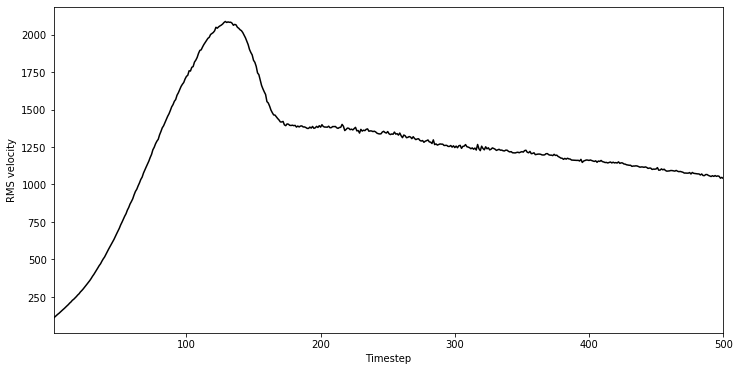

In [34]:
#figDensity.show()

#figStrainRate.show()

#uw.utils.matplotlib_inline()


import matplotlib.pyplot as pyplot
fig4 = pyplot.figure()
fig4.set_size_inches(12, 6)
ax= fig4.add_subplot(1,1,1)
ax.plot(timeVal, vrmsVal, color = 'black')
ax.set_xlabel('Timestep')
ax.set_ylabel('RMS velocity')
ax.set_xlim([1.0,nsteps])
fig4.savefig(outputPath+'vrms{}.png'.format(Trial))

Initial position: t = 0.000, x1 = 40.000, x2 = 42.500, y1 = 27.000, y2=22.000
Final position:   t = 15.054, x1 = 40.204, x2 = 42.657, y1 = 26.276, y2=0.690


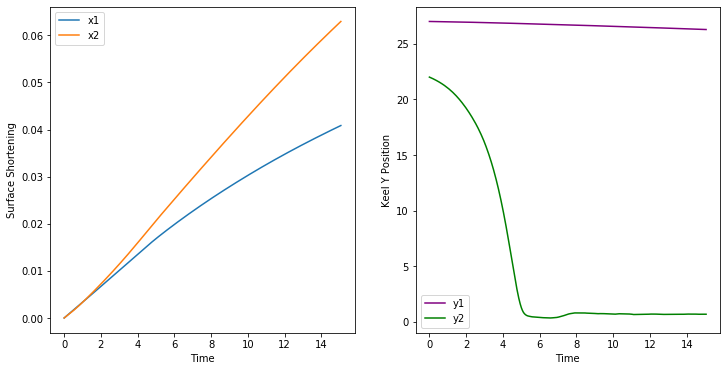

In [35]:
if rank==0:
    print('Initial position: t = {0:.3f}, x1 = {1:.3f}, x2 = {2:.3f}, y1 = {3:.3f}, y2={4:.3f}'.format(tTracers[0], xTracer1[0], xTracer2[0], yTracer3[0], yTracer4[0]))
    print('Final position:   t = {0:.3f}, x1 = {1:.3f}, x2 = {2:.3f}, y1 = {3:.3f}, y2={4:.3f}'.format(tTracers[nsteps-1], xTracer1[nsteps-1], xTracer2[nsteps-1], yTracer3[nsteps-1], yTracer4[nsteps-1]))

    #uw.utils.matplotlib_inline()
    figTracer1 = pyplot.figure()
    figTracer1.set_size_inches(12, 6)
    ax1 = figTracer1.add_subplot(1,2,1)
    ax1.plot(tTracers, Shortening1, label = "x1")
    ax1.plot(tTracers, Shortening2, label = "x2")
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Surface Shortening')
    ax1.legend()
    ax2 = figTracer1.add_subplot(1,2,2)
    ax2.plot(tTracers, yTracer3, color = "purple", label = "y1")
    ax2.plot(tTracers, yTracer4, color = "green", label = "y2")
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Keel Y Position')
    ax2.legend()
    figTracer1.savefig(outputPath+'FigTracer{}.png'.format(Trial))
    

In [42]:
np.savetxt(outputPath + "IceDripData{}.txt".format(Trial), (tTracers, xTracer1, xTracer2, yTracer3, yTracer4), fmt='%1.4e')


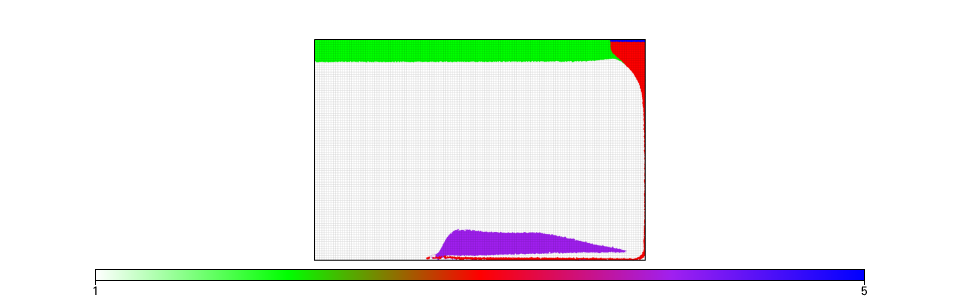

In [37]:
figParticle.show()